# Spis tresci

# Konwencje

In [4]:
import tensorflow as tf
import os
import re

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model, pad_sequences, load_img, img_to_array, to_categorical
from tensorflow.image import decode_jpeg
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.io import read_file
from pickle import dump, load
from nltk.translate.bleu_score import corpus_bleu
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from numpy import array, argmax
from matplotlib import pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

2023-05-17 21:20:21.929259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Wyciągnięcie wektora cech z obrazów

## 1.1 Funkcje pomocnicze

In [5]:
def show_img(img_id):
    """
    Wyswietla obraz i jego opisy.
    
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    
    jpg = decode_jpeg(read_file(f"data/fetched/{img_id}"), channels=3)
    file = open('data/info_on_images/Flickr8k.token.txt')
    im = plt.imshow(jpg)
    plt.axis('off')
    for r in file:
        if r.split('\t')[0][:-2] == img_id:
            print(r)
    file.close()

1089181217_ee1167f7af.jpg#0	a brown dog running down a paved pathway

1089181217_ee1167f7af.jpg#1	A brown dog running next to grass .

1089181217_ee1167f7af.jpg#2	A dog is running down a road .

1089181217_ee1167f7af.jpg#3	A light brown dog runs down a path happily .

1089181217_ee1167f7af.jpg#4	Energetic brown dog running



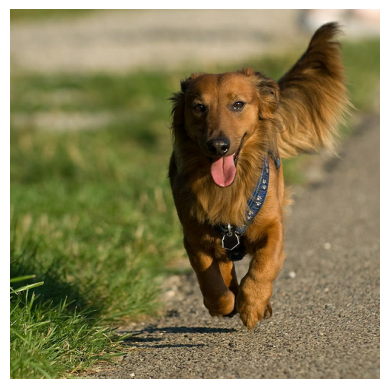

In [51]:
show_img('1089181217_ee1167f7af.jpg')

In [7]:
SIZE = (224, 224) # Docelowa wielkosc w jakiej bedziemy wczytywac obrazy

filename = "Flickr_8k.trainImages.txt"

path_to_info = "data/info_on_images/" + filename
path_to_image = "data/fetched/"

## 1.2 Stworzenie obiektu VGG16 - siec neuronowa typu _backbone_, ktora posluzy do wyciagniecia wektorow cech

In [4]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2023-05-16 11:04:45.166381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 11:04:45.167334: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 1.3 Wyciagniecie wektorow cech z obrazow

In [8]:
def get_features(path_to_images, path_to_ids):
    features_vectors = {}

    with open(path_to_ids, "r") as file:
        data = file.read().splitlines()

    for image_name in data:
        image = load_img(path_to_images + image_name, target_size=SIZE)
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

        image = preprocess_input(image)

        feature = model.predict(image, verbose=0)

        features_vectors[image_name] = feature
    return features_vectors

## 1.4 Zapisanie _pikla_ 

In [46]:
dump(get_features(path_to_image, path_to_info), open(os.path.join("utils", "features_inception.pkl"), "wb"))

## 1.5 Podsumowanie modelu

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 2. Wstepne przetwarzanie danych tekstowych

## 2.1 Definicja tokenow i wyrazow do potencjalnego usuniecia (stop words, czyli _wyrazy stopu_ to takie, ktore nie wnosza kontekstu do zdania np. _a, the, on_)

Jako początek sekwencji będziemy używali tokenu _startseq_, a do zakonczenia sekwencji uzyjemy _endseq_.

In [9]:
STOP_WORDS = set(stopwords.words('english'))
BEGIN = 'startseq'
END = 'endseq'
SEP = '###'

In [10]:
def is_stop_token(text):
    """
    Funkcja sprawdzajaca, czy wyraz jest tokenem poczatkowym/koncowym.
    :param: str text - wyraz do sprawdzenia
    
    :returns: boolean True - wyraz jest tokenem stopu / boolean False - nie jest tokenem stopu
    """
    global BEGIN, END
    return text == BEGIN or text == END


def text_preprocessing(text):
    """
    Funkcja, ktora wstepnie przetwarza cala linijke textu w nastepujacej kolejnosci:
    1. Zamienia wszystkie litery na male.
    2. Zamienia kazdy znak, ktory ani nie jest alfanumeryczny, ani nie jest spacja, na pusty znak.
    3. Zamienia wiele spacji na pojedyncza spacje.
    4. Usuwa znaki biale na koncu zdania.
    5. Dodaje tokeny poczatku i konca zdania.
    
    :param: str text - linijka do przetwarzania
    
    :returns: str text - przetworzona linijka
    """
    global STOP_WORDS, BEGIN, END
    stemmer = PorterStemmer()
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    text = BEGIN + ' ' + text + ' ' + END
    text = text.split()
    # text = list(filter(lambda x: (x not in STOP_WORDS or is_stop_token(x)) and not x.isnumeric(), text))
    text = " ".join(text)

    return text


def load_file(path):
    """
    Wczytuje plik tekstowy do pamieci czytajac go calego na raz i dzieli go ze wzgledu na znaki nowej linii.
    
    :param: str path - sciezka do pliku tekstowego
    
    :returns: list[str] text - wczytany plik w postaci listy linijek z pliku
    """
    with open(path, 'r') as file:
        text = file.read().splitlines()
    return text


def get_descriptions(text):
    """
    Przeczytaj plik z opisami zdjec i zwroc slownik, ktory danemu ID przyporzadkowuje wszystkie opisy do zdjec.
    
    :param: list[str] text - lista linijek opisujacych zdjecie w nastepujacym formacie - ID# OPIS
    
    :returns: dict[str, list[str]] - slownik, ktory danemu ID (str), przyporzadkowuje liste (list[str]) opisow do
    danego zdjecia.
    """
    descriptions = {}

    for line in text:
        id, desc = re.split('#\d\s+',line)
        if id not in descriptions:
            descriptions[id] = []
        descriptions[id].append(text_preprocessing(desc))
    return descriptions


def to_bag_of_words(descriptions):
    """
    Zwraca zbior wszystkich opisow. Opisy w formie tekstow, sa zamieniane na listy, podzielone ze wzgledu na znak
    spacji.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions)
    
    :returns: set[str] - zbior wszystkich wyrazow, ktore zostaly uzyte do opisow zdjec.
    """
    
    words = set()
    for key in descriptions.keys():
        [words.update(w.split(' ')) for w in descriptions[key]]
    return words


def save_descriptions_to_a_file(descriptions, path):
    """
    Zapisuje slownik do pliku w sciezce 'path'. Slownik zapisywany jest w nastepujacym formacie: ID{seperator}OPIS.
    
    :param: dict[str, list[str]] - slownik z opisami zdjec (patrz get_descriptions).
    :param: str path - sciezka do pliku
    
    :returns: None
    """
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + SEP + desc)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

## 2.2 Wczytanie pliku z opisami do zdjec

In [13]:
filename = 'data/info_on_images/Flickr8k.token.txt'
doc = load_file(filename)

## 2.3 Ekstrakcja opisow do zdjec

In [12]:
descriptions = get_descriptions(doc)
print('Liczba wczytanych opisow: %d ' % len(descriptions))

Liczba wczytanych opisow: 8092 


## 2.4 Stworzenie slownika wszystkich slow uzytych do opisow zdjec

In [14]:
vocabulary = to_bag_of_words(descriptions)
print('Wielkosc slownika: %d' % len(vocabulary))

Wielkosc slownika: 8830


In [23]:
save_descriptions_to_a_file(descriptions, 'utils/descriptions.txt')

# 3. Przygotowanie do uczenia modelu

## 3.1 Funkcje odpowiedzialne za proces tokenizacji podczas przetwarzania tekstu

In [15]:
def create_tokenizer(description_list):
    """
    Tworzy obiekt klasy Tokenizer na podstawie listy wszystkich opisow.
    
    :param: list[str] description_list  - lista wszystkich opisow
    
    :returns: tokenizer
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(description_list)
    return tokenizer

def get_reverse_tokenizer(tokenizer: Tokenizer):
    """
    Odwraca dzialanie tokenizacji.
    Jako ze Tokenizer domyslnie, dopasowuje napis do liczby, to nalezy rowniez ten proces odwrocic, aby
    odkodowac przewidziany opis.
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: dict[int, str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return {v:k for (k,v) in tokenizer.word_index.items()}

#### Przyklad:

In [10]:
tok = create_tokenizer(['A dog is running', 'A kid is playing on a playground with their dog'])
tok.word_index

{'a': 1,
 'dog': 2,
 'is': 3,
 'running': 4,
 'kid': 5,
 'playing': 6,
 'on': 7,
 'playground': 8,
 'with': 9,
 'their': 10}

Powyzej, bardzo dobrze widac, ze tokenizer nadaje nizsze indexy, tokenom ktore czesciej wystepuja w opisach.

## 3.1 Funkcje pozwalajace na podawanie opisow do modelu

Proponowane rozwiazanie uzywa _generatora_, ktory posluzy za podawanie kolejnych wartosci. Maszyna, na ktorej trenowany bedzie model ma tylko 16GB pamieci RAM, takze niemozliwe bedzie zaladowanie do pamieci na raz 6000 opisow do obrazow.

In [16]:
def generate_data(descriptions, features, tokenizer, max_length, vocab_size):
    """
    Pythonowy generator, ktory 'oddaje' sekwencje do modelu RNN (rekurencyjna siec neuronowa).
    
    :param: dict[str, list[str]] descriptions - opisy do zdjec (patrz get_descriptions)
    :param: features[str, ]
    """
    while 1:
        for key, desc_list in descriptions.items():
            feature = features[key][0]

            input_img, input_seq, output_seq = create_sequences(tokenizer, max_length, desc_list, feature, vocab_size)
            yield [[input_img, input_seq], output_seq]


def create_sequences(tokenizer, max_length, desc_list, feature, vocab_size):
    """
    Tworzy sekwencje wejściowe i wyjściowe dla opisów obrazków dla rekurencyjnych sieci neuronowych, ktore
    predykuja nastepne slowo na podstawie sekwencji. np:
    input seq: startseq a dog is 
    output seq: running

    :param: Tokenizer tokenizer -  obiekt tokenizer z biblioteki keras
    :param: int max_length: maksymalna długość sekwencji
    :param: list[str] desc_list  - lista opisów obrazków
    :param: dict[str, np.array] feature - wektor cech obrazow
    :param: int vocab_size: rozmiar słownika
    
    :return: trzy wartości: macierz z cechami obrazów, macierz sekwencji wejściowych oraz macierz sekwencji wyjściowych
    """
    photo_for_seq, input_sequences, output_for_seq = [], [], []
    
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            # input sekwencja do i-tego wyrazu, a output to i-ty wyraz
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # dodaj do arrays nastepujace elementy: wektor_cech, input_sequence, output_sequence
            photo_for_seq.append(feature)
            input_sequences.append(in_seq)
            output_for_seq.append(out_seq)
    return array(photo_for_seq), array(input_sequences), array(output_for_seq)

## 3.4 Funkcje pomocnicze

Do trenowania modelu, bedziemy tez potrzebowali funkcji, ktore pozwola nam okresli dlugosc najdluzszej sekwencji, ktora model powinien generowac, wielkosc slownika (tokenizer), oraz funkcji ktora pozwoli _wyplaszczyc_ dwuwymiarowa liste, do jednowymiarowej.

In [17]:
def max_len(flattened_descriptions):
    """
    Zwraca dlugosc najdluzszego opisu do zdjec.
    
    :param: list[str] flattened_descriptions - wszystkie opisy do zdjec.
    
    :returns: int x - dlugosc najdluzszego opisu.
    """
    return max((len(l) for l in flattened_descriptions))



def size_of_vocab(tokenizer):
    """
    Zwraca wielkosc slownika. 
    
    :param: Tokenizer tokenizer - obiekt tokenizer z biblioteki keras
    
    :returns: int x - wielkość docelowego słownika
    """
    return len(tokenizer.word_index) + 1

def flatten_descriptions(descriptions):
    """
    Splaszcza opisy obrazkow. Tworzy ze slownika (ktory do klucza przypisane ma wiele opisow), 
    liste jednowymiarowa tychze opisow.
    
    :param: dict[str, list[str]] descriptions - slownik opisow obrazkow (patrz get_descriptions)
    
    :returns: list[str] - slownik przypisowujacy liczbie, odpowiadajacy jej napis
    """
    return [item for sub in descriptions.values() for item in sub]

# 4. Wczytanie przetworzonych danych

Potrzebujemy wczytac do pamieci _zpiklowane_ wczesniej obiekty (przetworzone opisy, wektory cech), zeby wykorzystac w procesie uczenia.

In [18]:
def get_clean_descriptions(image_ids, descriptions_path):
    """
    Zwraca zapisane opisy juz po wczesnym przetwarzaniu (patrz save_descriptions_to_file). 
    
    :param: list[str] image_ids - lista id obrazow
    :param: str descriptions_path - sciezka do pliku z opisami
    
    :returns: dict[str, list[str]] - slownik, ktory przyporzadkowuje zdjeciu wszystkie przetworzone opisy
    """
    descriptions = load_file(descriptions_path)
    descriptions = list(map(lambda x: x.split(SEP), descriptions))
    multiple_descriptions = {}
    for k,v in descriptions:
        if k not in image_ids:
            continue
        elif k not in multiple_descriptions:
            multiple_descriptions[k] = []
        multiple_descriptions[k].append(v)

    return multiple_descriptions


def get_feature_vector(image_ids, features_path):
    """
    Zwraca zapisany dziennik, ktory jest ograniczony do tych kluczy z image-ids
    
    :param: list[str] image_ids - lista id obrazow
    :param: str features_path - sciezka do pliku ze spiklowanym slownikiem
    
    :returns: dict[str, np.array] - zapisany slownik
    """
    features_vectors = load(open(features_path, 'rb'))
    return {k:v for (k,v) in features_vectors.items() if k in image_ids}

### Na podstawie poniższego pliku, będzie trenowany model, zmiana pliku na walidacyjny/testowy/treningowy pozwala wytrenować/przetestować model.

In [19]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [20]:
descriptions = get_clean_descriptions(load_file(filename), 'utils/descriptions.txt')
flatten = flatten_descriptions(descriptions)

features = get_feature_vector(descriptions.keys(), 'utils/features_inception.pkl')
tokenizer = create_tokenizer(flatten)

length = max_len([i.split() for i in flatten])
size = len(to_bag_of_words(descriptions))

In [16]:
dump(tokenizer, open('utils/tokenizer.pkl','wb'))

# 5. Trenowanie modelu

Ponizsza funkcja pozwala na stworzenei samego modelu. Architektura, jest zgodna z plikiem _utils/model.png_, ktory jest generowany przy tworzeniu modelu.

In [21]:
def create_model(vocab_size, max_length_of_seq):
    """
    Tworzy model zgodnie z architektura, przedstawiona w katalogu utils/model.png. Model sluzy do generacji
    opisu do obrazka podanego na wejsciu modelu przy predykcji.
    
    :param: int vocab_size - wielkosc slownika
    :param: int max_length_of_seq - maksymalna dlugosc generowanego zdania
    
    :returns: keras.model.Model - model
    """
    image_input = Input(shape=(2048,))
    image = Dropout(0.5)(image_input)
    image = Dense(256, activation='relu')(image)

    sequences_input = Input(shape=(max_length_of_seq,))
    sequences = Embedding(vocab_size, 256, mask_zero=True)(sequences_input)
    sequences = Dropout(0.5)(sequences)
    sequences = LSTM(256)(sequences)

    decoder = add([image, sequences])
    decoder = Dense(256, activation='relu')(decoder)
    output = Dense(vocab_size, activation='softmax')(decoder)

    model = Model(inputs=[image_input, sequences_input], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='utils/model.png', show_shapes=True)

    return model

Potrzebna tez jest funkcja ktora pozwoli na samo trenowanie modelu. Wykorzystamy w tym celu wczesniej utworzone funkcje, miedzy innymi wczytywanie opisow, wektorow cech, tworzenia modelu itd.

Po kazdej epoce, model bedzie zapisywany w katalogu _models_.

In [22]:
def train_model(file_path, epochs, model, c=-1):
    """
    Trenuje model, w oparciu o plik z opisami w file_path. Po jednej epoce, model jest zapisywany w models/
    
    :param: str file_path - sciezka do pliku z przetworzonymi opisami
    :param: int epochs - liczba epok
    :param: keras.model.Model model - model do wytrenowania
    :param: int c - liczba obrazow, ktora jest brana pod uwage przy trenowaniu    
    :returns: None
    """
    train_images = load_file(file_path)
    
    if c != -1:
        train_images = load_file(file_path)[:c]
        
    features = get_feature_vector(train_images, "utils/features_inception.pkl")
    descriptions = get_clean_descriptions(train_images, "utils/descriptions.txt")
    flatten_description = flatten_descriptions(descriptions)
    tokenizer = create_tokenizer(flatten_description)

    vocab_size = size_of_vocab(tokenizer)
    max_length = max_len(flatten_description)
    model = create_model(vocab_size, max_length)

    steps = len(flatten_description)
    for i in range(epochs):
        gen = generate_data(descriptions, features, tokenizer, max_length, vocab_size)
        model.fit(gen, epochs=1, steps_per_epoch=steps,verbose=1)
        model.save('models/model_inception_v' + str(i) + '.h5')

In [19]:
filename = 'data/info_on_images/Flickr_8k.trainImages.txt'

In [ ]:
train_model(filename, 5, create_model(size, length))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 38, 256)      1953792     ['input_7[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

# 6. Ewaluacja

Samo wytrenowanie modelu nie wystarczy, trzeba przede wszystkim sprawdzic jego dzialanie na pojedynczym zdjeciu, oraz trzeba sprawdzic jego wydajnosc na innym zbiorze danych.

In [30]:
def predict_description(model, tokenizer: Tokenizer, photo, max_length):
    input = BEGIN
    reversed_tokenizer = get_reverse_tokenizer(tokenizer)
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_predict = model.predict([photo, sequence], verbose=0)
        y_predict = argmax(y_predict)

        predicted_word: str = reversed_tokenizer[y_predict]

        if predicted_word == None:
            break

        input += " " + predicted_word

        if predicted_word == END:
            break
    prediction = input
    prediction = " ".join(prediction.split(" ")[1:-1]).capitalize()
    return prediction

def get_clean_descriptions(filename, photo_ids):
    descs = get_descriptions(load_file(filename))
    return {k:v for (k,v) in descs.items() if k.split('.')[0] in photo_ids}

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    y, y_pred = [], []
    for k, desc_list in descriptions.items():
        predicted_description = predict_description(model, tokenizer, photos[k], max_length)
        refs = [desc.split() for desc in desc_list]
        y.append(refs)
        y_pred.append(predicted_description.split())
    print('BLEU-1: %f' % corpus_bleu(y, y_pred, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, y_pred, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, y_pred, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, y_pred, weights=(0.25, 0.25, 0.25, 0.25)))
    
def get_photo_ids(filename):
    text = load_file(filename)
    return [i.split('.')[0] for i in text]

def extract_features(path_image, model):
    
    image = load_img(path_image, target_size=SIZE)
    image = img_to_array(image)
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    image = preprocess_input(image)

    return model.predict(image, verbose=0)

#### Ekstrakcja wektora cech

In [55]:
extractor = VGG16()
extractor = Model(inputs=extractor.inputs, outputs=extractor.layers[-2].output)

In [56]:
photo = extract_features('./dog.jpg', extractor)
photo

array([[0.       , 0.       , 4.7995973, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

#### Predykcja podpisu do obrazka

In [57]:
model = load_model('models/model_v1.h5')
path_to_img = './dog.jpg'

tokenizer = load(open('utils/tokenizer.pkl', 'rb')) # wciągnięcie słownika i tokenów

predict_description(model, tokenizer, photo, 210)

'A dog is running through the grass'

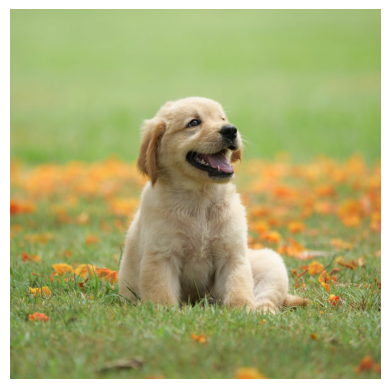

In [44]:
plt.axis('off')
plt.imshow(decode_jpeg(read_file('dog.jpg'), channels=3));

## Wnioski

Jak widać, model dość dobrze poradził sobie z predykcją podpisu do wyżej pokazanego obrazka.

Widać, że poradził sobie z rozpoznaniem psa, jak i trawy. Nie poradził sobie natomiast z rozpoznaniem ruchu wykonywanego przez psa. Może być to spowodowane obrazami, na podstawie których model był uczony. 

Jeśli większość psów, które model dostawał w procesie uczenia, wykonywała czynność biegania, to też model z większą pewnością, był w stanie stwierdzić, że jeśli na obrazie już zlokalizował psa, to też pewnie ten pies będzie biegł. 

Aby temu zapobiec, należałoby zwiększyć liczbę obiektów, na podstawie których model był uczony. Jest to jeden z wielu przypadków, które zapewne można zaobserwować (_więcej w sekcji Przykłady_).

In [45]:
test_path = 'data/info_on_images/Flickr_8k.testImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'
ids = get_photo_ids(test_path)
descs = get_clean_descriptions(descriptions_path, ids)
extracted_features = load(open('utils/features.pkl','rb'))

In [80]:
model = load_model('models/model_unstemmed_3.h5')

In [63]:
evaluate_model(model,descs,extracted_features,tokenizer,max_len_of_description)

BLEU-1: 0.419591
BLEU-2: 0.231084
BLEU-3: 0.142975
BLEU-4: 0.060824


Jak widać, na podstawie powyższych wyników, ciężko stwierdzić, czy wydajność modelu jest wystarczająca. Metryka BLEU, pozwala na ewaluacje jakości modelu translacyjnego. Mierzy ona podobieństwo między wygenerowanym przez maszynę tekstem, oraz tekstem referencyjnym, przy użyciu n-gramów. W tym przypadku, widzimy że model był w stanie poprawnie wygenerować 23% bigramów, czyli par tokenów, które się pokrywały z tekstem referencyjnym.

# 7. Przykłady

In [81]:
from random import choice
count = 4
path = 'data/fetched'
ids = [choice(os.listdir(path)) for _ in range(count)]
ids

['3545793128_af3af544dc.jpg',
 '110595925_f3395c8bd6.jpg',
 '3368819708_0bfa0808f8.jpg',
 '427936315_0b8f7b8d23.jpg']

3545793128_af3af544dc.jpg#0	A crowd of people gathered together and one woman is standing and holding a sign .

3545793128_af3af544dc.jpg#1	A group of fans gather for some type of event .

3545793128_af3af544dc.jpg#2	Asian crowd with attractive woman in foreground

3545793128_af3af544dc.jpg#3	Girl in a black and red shirt is standing up with a pole in her hand surrounded by people .

3545793128_af3af544dc.jpg#4	Young woman standing above a crowd .



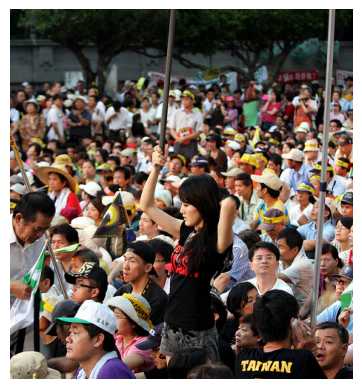

In [82]:
identyfikator = ids[0]
show_img(identyfikator)

In [83]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), 34)

'A man in a red shirt is sitting on a bench with a red and white striped bag'

110595925_f3395c8bd6.jpg#0	A cyclist is riding a bicycle on a curved road up a hill .

110595925_f3395c8bd6.jpg#1	A man in aerodynamic gear riding a bicycle down a road around a sharp curve .

110595925_f3395c8bd6.jpg#2	A man on a mountain bike is pedaling up a hill .

110595925_f3395c8bd6.jpg#3	Man bicycle up a road , while cows graze on a hill nearby .

110595925_f3395c8bd6.jpg#4	The biker is riding around a curve in the road .



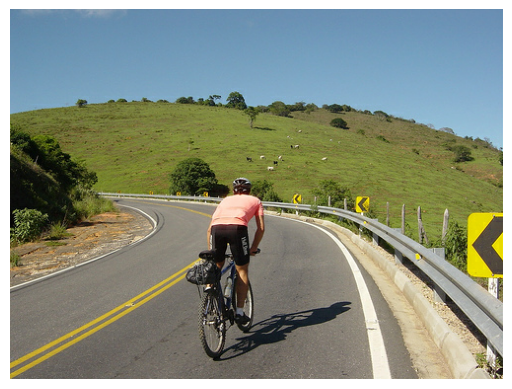

In [84]:
identyfikator = ids[1]
show_img(identyfikator)

In [85]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor),210)

'A man is riding a bike on a dirt path'

3368819708_0bfa0808f8.jpg#0	A snowboarder dressed in yellow makes a jump .

3368819708_0bfa0808f8.jpg#1	a snowboarder gets air off a jump .

3368819708_0bfa0808f8.jpg#2	A snowboarder is doing a trick .

3368819708_0bfa0808f8.jpg#3	A snowboarder jumping .

3368819708_0bfa0808f8.jpg#4	A viewer from a helicopter watches a snowboarder below



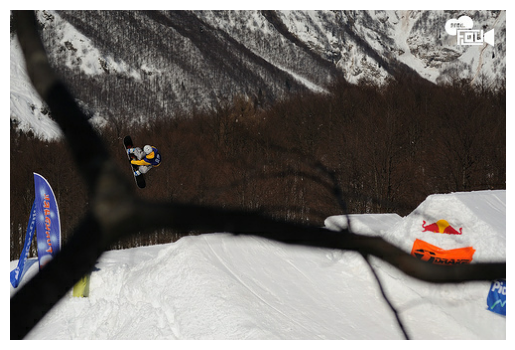

In [86]:
identyfikator = ids[2]
show_img(identyfikator)

In [87]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'A man is climbing up a rock'

427936315_0b8f7b8d23.jpg#0	A brown dog is chasing a red Frisbee across a grassy field .

427936315_0b8f7b8d23.jpg#1	A dog leaps in the air to catch a red Frisbee .

427936315_0b8f7b8d23.jpg#2	a dog runs for a red Frisbee .

427936315_0b8f7b8d23.jpg#3	A dog surrounded by trees runs to catch a Frisbee .

427936315_0b8f7b8d23.jpg#4	The large brown dog is running through the grass to catch a red Frisbee .



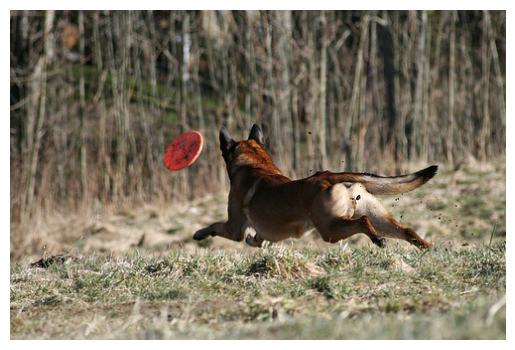

In [88]:
identyfikator = ids[3]
show_img(identyfikator)

In [89]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator, extractor), length)

'A dog is running through a field'

# 8. Porównanie modelu _backbone_ VGG16 i InceptionV3

Do wyciągania wektorów cech, wykorzystamy również model _InceptionV3_ i porównamy wyniki, które owe modele generują.

Poniżej przedstawiono poglądowe architektury poniższych modeli. Należy zwrócić jednak uwagę, że w naszym wypadku, jako że używamy tych modeli do ekstrakcji wektora cech, to ostatnia warstwa jest odłączona od modelu.

# 8.1 Architektura VGG16

<div style="text-align:center">
    <img src="utils/vgg16.png" alt="Image" width="600">
</div>


# 8.2 Architektura InceptionV3

<div style="text-align:center">
    <img src="utils/inception.png" alt="Image" height=200>
</div>


# 8.3 Przykłady opisu do zdjęcia według modelu

## 8.3.1 VGG16

In [33]:
model = load_model('models/model_v1.h5')

In [ ]:
identyfikator = ""

1352398363_9cc8ffcce9.jpg#0	A boy is covered with marker .

1352398363_9cc8ffcce9.jpg#1	A dirty child plays in the house

1352398363_9cc8ffcce9.jpg#2	A small boy wearing a diaper stands near the door and is covered in marker .

1352398363_9cc8ffcce9.jpg#3	A young boy covered in ink stands in front of a white door .

1352398363_9cc8ffcce9.jpg#4	A young boy in a pullup is covered in marker ink .



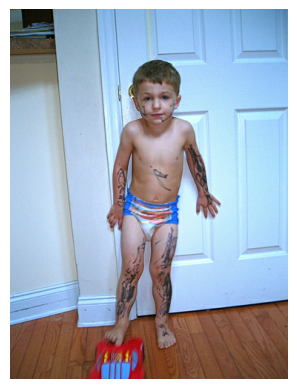

In [104]:
show_img(identyfikator)

In [105]:
predict_description(model, tokenizer, extract_features(path+'/'+identyfikator),max_len_of_description)

'A boy is running in a pool'

## 8.3.1 InceptionV3

In [33]:
model = load_model('models/model_inception_v2.h5')

1352398363_9cc8ffcce9.jpg#0	A boy is covered with marker .

1352398363_9cc8ffcce9.jpg#1	A dirty child plays in the house

1352398363_9cc8ffcce9.jpg#2	A small boy wearing a diaper stands near the door and is covered in marker .

1352398363_9cc8ffcce9.jpg#3	A young boy covered in ink stands in front of a white door .

1352398363_9cc8ffcce9.jpg#4	A young boy in a pullup is covered in marker ink .



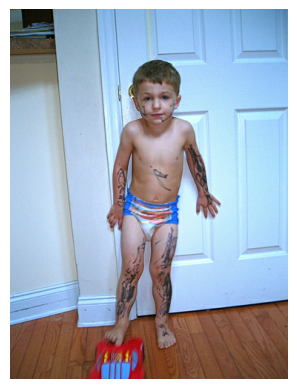

In [104]:
show_img(identyfikator)

# 8.4 Metryki BLEU po wytrenowaniu dla całego zbioru danych

In [25]:
test_path = 'data/info_on_images/Flickr_8k.testImages.txt'
descriptions_path =  'data/info_on_images/Flickr8k.token.txt'
ids = get_photo_ids(test_path)
descs = get_clean_descriptions(descriptions_path, ids)
extracted_features = load(open('utils/features_inception.pkl','rb'))

##  8.4.1 VGG16

In [33]:
model = load_model('models/model_v1.h5')

In [63]:
evaluate_model(model,descs,extracted_features,tokenizer,max_len_of_description)

BLEU-1: 0.419591
BLEU-2: 0.231084
BLEU-3: 0.142975
BLEU-4: 0.060824


## 8.4.2 InceptionV3

In [33]:
model = load_model('models/model_inception_v2.h5')

In [63]:
evaluate_model(model,descs,extracted_features,tokenizer,max_len_of_description)

BLEU-1: 0.419591
BLEU-2: 0.231084
BLEU-3: 0.142975
BLEU-4: 0.060824
